In [1]:
import os
os.chdir( "../")

In [2]:
import pandas as pd
import numpy as np
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

path = "Dataset/data_train.csv"
df = pd.read_csv(filepath_or_buffer=path,
                               sep=",",
                               header=1,
                               engine='python',
                               names=['UserID', 'ItemID', 'Interaction'])


df

,UserID,ItemID,Interaction
0,1,15,1.0
1,1,16,1.0
2,1,133,1.0
3,1,161,1.0
4,1,187,1.0
...,...,...,...
478724,13024,13605,1.0
478725,13024,13823,1.0
478726,13024,15122,1.0
478727,13024,18185,1.0


In [3]:
df.Interaction.value_counts()

1.0    478729
Name: Interaction, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478729 entries, 0 to 478728
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UserID       478729 non-null  int64  
 1   ItemID       478729 non-null  int64  
 2   Interaction  478729 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [5]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [6]:
df.head()

,UserID,ItemID,Interaction,User,Item
0,1,15,1.0,0,0
1,1,16,1.0,0,1
2,1,133,1.0,0,2
3,1,161,1.0,0,3
4,1,187,1.0,0,4


In [7]:
userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.sparse as sps


URM_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)


In [9]:
num_users = len(userId_unique)
num_items = len(itemId_unique)

In [10]:
URM_all, URM_train, URM_test, URM_validation, URM_train_validation

(<12638x22222 sparse matrix of type '<class 'numpy.float32'>'
 	with 478729 stored elements in COOrdinate format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 306386 stored elements in Compressed Sparse Row format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 95746 stored elements in Compressed Sparse Row format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 76597 stored elements in Compressed Sparse Row format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 382983 stored elements in Compressed Sparse Row format>)

In [11]:
from Recommenders.Recommender_import_list import *
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10], ignore_users=[])

2023-12-08 21:51:23.267747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-08 21:51:23.267778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


EvaluatorHoldout: Ignoring 2602 (20.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


## Insert model here

In [12]:
model = ItemKNNCFRecommender

In [13]:
import optuna as op

def objective(trial):

    hyperparameters_range_dictionary = {
        "topK": trial.suggest_int("topK",5, 1000),
        "shrink": trial.suggest_int("shrink",0, 1000),
        "similarity": trial.suggest_categorical("similarity",["tversky", "dice", "jaccard", "tanimoto"]),
        "normalize": trial.suggest_categorical("normalize",[True,False]),
    }
    
    recommender = model(URM_train)
    recommender.fit(**hyperparameters_range_dictionary)
    
    result, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_result = result["MAP"].item()
       
    return MAP_result

In [14]:
rp3_best_params = {'topK': 29,
 'alpha': 0.33723025040409343,
 'beta': 0.15542352567862933,
 'normalize_similarity': True}



study = op.create_study(direction="maximize")
#study.enqueue_trial(best_params)

study.optimize(objective, n_trials=250)

[I 2023-12-08 21:51:23,981] A new study created in memory with name: no-name-0475663d-c087-4b24-844f-40d8eaa21918


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13165.19 column/sec. Elapsed time 1.69 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.81 sec. Users per second: 2632


[I 2023-12-08 21:51:29,545] Trial 0 finished with value: 0.02608764005137067 and parameters: {'topK': 136, 'shrink': 62, 'similarity': 'dice', 'normalize': False}. Best is trial 0 with value: 0.02608764005137067.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12667.35 column/sec. Elapsed time 1.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.98 sec. Users per second: 2014


[I 2023-12-08 21:51:36,403] Trial 1 finished with value: 0.024691317605825422 and parameters: {'topK': 346, 'shrink': 108, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 0 with value: 0.02608764005137067.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12337.42 column/sec. Elapsed time 1.80 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.36 sec. Users per second: 1872


[I 2023-12-08 21:51:43,665] Trial 2 finished with value: 0.021577025090626166 and parameters: {'topK': 317, 'shrink': 528, 'similarity': 'jaccard', 'normalize': False}. Best is trial 0 with value: 0.02608764005137067.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12648.42 column/sec. Elapsed time 1.76 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.91 sec. Users per second: 1698


[I 2023-12-08 21:51:51,513] Trial 3 finished with value: 0.0212547250533002 and parameters: {'topK': 796, 'shrink': 269, 'similarity': 'dice', 'normalize': True}. Best is trial 0 with value: 0.02608764005137067.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12426.65 column/sec. Elapsed time 1.79 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.97 sec. Users per second: 2018


[I 2023-12-08 21:51:58,350] Trial 4 finished with value: 0.020459872237722023 and parameters: {'topK': 240, 'shrink': 972, 'similarity': 'dice', 'normalize': False}. Best is trial 0 with value: 0.02608764005137067.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12780.67 column/sec. Elapsed time 1.74 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.81 sec. Users per second: 1726


[I 2023-12-08 21:52:06,064] Trial 5 finished with value: 0.02236290228194375 and parameters: {'topK': 683, 'shrink': 178, 'similarity': 'dice', 'normalize': False}. Best is trial 0 with value: 0.02608764005137067.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12945.05 column/sec. Elapsed time 1.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.01 sec. Users per second: 2505


[I 2023-12-08 21:52:11,852] Trial 6 finished with value: 0.026329562780340054 and parameters: {'topK': 175, 'shrink': 50, 'similarity': 'tversky', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12635.44 column/sec. Elapsed time 1.76 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.85 sec. Users per second: 1717


[I 2023-12-08 21:52:19,631] Trial 7 finished with value: 0.01924159929017439 and parameters: {'topK': 791, 'shrink': 606, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12875.88 column/sec. Elapsed time 1.73 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.09 sec. Users per second: 1972


[I 2023-12-08 21:52:26,528] Trial 8 finished with value: 0.023237661877558297 and parameters: {'topK': 260, 'shrink': 321, 'similarity': 'tanimoto', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12436.48 column/sec. Elapsed time 1.79 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.71 sec. Users per second: 1758


[I 2023-12-08 21:52:34,150] Trial 9 finished with value: 0.01912064187970926 and parameters: {'topK': 458, 'shrink': 946, 'similarity': 'tversky', 'normalize': True}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13371.61 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.62 sec. Users per second: 2769


[I 2023-12-08 21:52:39,473] Trial 10 finished with value: 0.02344143622641043 and parameters: {'topK': 34, 'shrink': 689, 'similarity': 'tversky', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13238.44 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.51 sec. Users per second: 3991


[I 2023-12-08 21:52:43,699] Trial 11 finished with value: 0.025578773558048204 and parameters: {'topK': 23, 'shrink': 1, 'similarity': 'tversky', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12760.82 column/sec. Elapsed time 1.74 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.36 sec. Users per second: 2300


[I 2023-12-08 21:52:49,863] Trial 12 finished with value: 0.02393085685184134 and parameters: {'topK': 123, 'shrink': 333, 'similarity': 'jaccard', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12714.03 column/sec. Elapsed time 1.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.87 sec. Users per second: 2062


[I 2023-12-08 21:52:56,636] Trial 13 finished with value: 0.023444741786710754 and parameters: {'topK': 465, 'shrink': 1, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12445.69 column/sec. Elapsed time 1.79 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.55 sec. Users per second: 2207


[I 2023-12-08 21:53:03,037] Trial 14 finished with value: 0.02332182318257449 and parameters: {'topK': 154, 'shrink': 409, 'similarity': 'tversky', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12667.84 column/sec. Elapsed time 1.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.66 sec. Users per second: 1772


[I 2023-12-08 21:53:10,620] Trial 15 finished with value: 0.02271676330290323 and parameters: {'topK': 618, 'shrink': 155, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13077.28 column/sec. Elapsed time 1.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.82 sec. Users per second: 2081


[I 2023-12-08 21:53:17,213] Trial 16 finished with value: 0.021705894494106936 and parameters: {'topK': 163, 'shrink': 794, 'similarity': 'tversky', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12851.04 column/sec. Elapsed time 1.73 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.29 sec. Users per second: 1898


[I 2023-12-08 21:53:24,340] Trial 17 finished with value: 0.02454923782320158 and parameters: {'topK': 386, 'shrink': 101, 'similarity': 'jaccard', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13265.32 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.59 sec. Users per second: 1796


[I 2023-12-08 21:53:31,764] Trial 18 finished with value: 0.020624841839220105 and parameters: {'topK': 561, 'shrink': 439, 'similarity': 'tversky', 'normalize': True}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12515.85 column/sec. Elapsed time 1.78 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 6.01 sec. Users per second: 1670


[I 2023-12-08 21:53:39,784] Trial 19 finished with value: 0.021620890982937586 and parameters: {'topK': 893, 'shrink': 239, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13020.91 column/sec. Elapsed time 1.71 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.53 sec. Users per second: 2841


[I 2023-12-08 21:53:45,078] Trial 20 finished with value: 0.025833155402456003 and parameters: {'topK': 115, 'shrink': 85, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13028.97 column/sec. Elapsed time 1.71 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.45 sec. Users per second: 2905


[I 2023-12-08 21:53:50,294] Trial 21 finished with value: 0.026181638956898096 and parameters: {'topK': 89, 'shrink': 66, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12886.91 column/sec. Elapsed time 1.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.87 sec. Users per second: 2062


[I 2023-12-08 21:53:56,974] Trial 22 finished with value: 0.024185124029683716 and parameters: {'topK': 223, 'shrink': 208, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13258.33 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.53 sec. Users per second: 3970


[I 2023-12-08 21:54:01,213] Trial 23 finished with value: 0.024980206178392656 and parameters: {'topK': 32, 'shrink': 0, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12648.73 column/sec. Elapsed time 1.76 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.61 sec. Users per second: 2783


[I 2023-12-08 21:54:06,628] Trial 24 finished with value: 0.026082519596120665 and parameters: {'topK': 109, 'shrink': 63, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12664.31 column/sec. Elapsed time 1.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.71 sec. Users per second: 2129


[I 2023-12-08 21:54:13,174] Trial 25 finished with value: 0.023640738579210147 and parameters: {'topK': 203, 'shrink': 306, 'similarity': 'tversky', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12906.62 column/sec. Elapsed time 1.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.09 sec. Users per second: 1973


[I 2023-12-08 21:54:20,092] Trial 26 finished with value: 0.0243314069350339 and parameters: {'topK': 295, 'shrink': 169, 'similarity': 'jaccard', 'normalize': True}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13039.38 column/sec. Elapsed time 1.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.49 sec. Users per second: 1829


[I 2023-12-08 21:54:27,397] Trial 27 finished with value: 0.02186594134132992 and parameters: {'topK': 381, 'shrink': 410, 'similarity': 'tanimoto', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13013.20 column/sec. Elapsed time 1.71 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.45 sec. Users per second: 2911


[I 2023-12-08 21:54:32,604] Trial 28 finished with value: 0.026237501344366726 and parameters: {'topK': 83, 'shrink': 65, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12709.13 column/sec. Elapsed time 1.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.42 sec. Users per second: 2934


[I 2023-12-08 21:54:37,821] Trial 29 finished with value: 0.025471461468870825 and parameters: {'topK': 71, 'shrink': 129, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12775.58 column/sec. Elapsed time 1.74 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.81 sec. Users per second: 2088


[I 2023-12-08 21:54:44,443] Trial 30 finished with value: 0.024260396698868286 and parameters: {'topK': 197, 'shrink': 228, 'similarity': 'tversky', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12764.46 column/sec. Elapsed time 1.74 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.34 sec. Users per second: 3006


[I 2023-12-08 21:54:49,570] Trial 31 finished with value: 0.026240569663497183 and parameters: {'topK': 86, 'shrink': 66, 'similarity': 'dice', 'normalize': False}. Best is trial 6 with value: 0.026329562780340054.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13339.83 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.30 sec. Users per second: 4358


[I 2023-12-08 21:54:53,568] Trial 32 finished with value: 0.026455798806835195 and parameters: {'topK': 5, 'shrink': 63, 'similarity': 'dice', 'normalize': False}. Best is trial 32 with value: 0.026455798806835195.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12478.49 column/sec. Elapsed time 1.78 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.64 sec. Users per second: 3800


[I 2023-12-08 21:54:58,024] Trial 33 finished with value: 0.026610033245396104 and parameters: {'topK': 34, 'shrink': 51, 'similarity': 'dice', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12901.69 column/sec. Elapsed time 1.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.48 sec. Users per second: 4054


[I 2023-12-08 21:55:02,252] Trial 34 finished with value: 0.025398371418449164 and parameters: {'topK': 5, 'shrink': 130, 'similarity': 'dice', 'normalize': True}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12650.29 column/sec. Elapsed time 1.76 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.96 sec. Users per second: 2532


[I 2023-12-08 21:55:08,041] Trial 35 finished with value: 0.026143462898644353 and parameters: {'topK': 170, 'shrink': 36, 'similarity': 'dice', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13218.37 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.93 sec. Users per second: 2035


[I 2023-12-08 21:55:14,746] Trial 36 finished with value: 0.02336850433676863 and parameters: {'topK': 286, 'shrink': 285, 'similarity': 'tanimoto', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13342.02 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.51 sec. Users per second: 2858


[I 2023-12-08 21:55:19,965] Trial 37 finished with value: 0.025197250216680296 and parameters: {'topK': 78, 'shrink': 167, 'similarity': 'dice', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12956.07 column/sec. Elapsed time 1.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.23 sec. Users per second: 1919


[I 2023-12-08 21:55:27,016] Trial 38 finished with value: 0.023453235020592534 and parameters: {'topK': 345, 'shrink': 219, 'similarity': 'jaccard', 'normalize': True}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13463.77 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.97 sec. Users per second: 2021


[I 2023-12-08 21:55:33,717] Trial 39 finished with value: 0.02223710910563248 and parameters: {'topK': 247, 'shrink': 491, 'similarity': 'dice', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13492.59 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.94 sec. Users per second: 1691


[I 2023-12-08 21:55:41,519] Trial 40 finished with value: 0.02068598679673806 and parameters: {'topK': 1000, 'shrink': 354, 'similarity': 'tanimoto', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13458.21 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.04 sec. Users per second: 3298


[I 2023-12-08 21:55:46,255] Trial 41 finished with value: 0.026339451783104737 and parameters: {'topK': 61, 'shrink': 65, 'similarity': 'dice', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12764.54 column/sec. Elapsed time 1.74 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.56 sec. Users per second: 3924


[I 2023-12-08 21:55:50,584] Trial 42 finished with value: 0.026276831976313923 and parameters: {'topK': 10, 'shrink': 102, 'similarity': 'dice', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12966.51 column/sec. Elapsed time 1.71 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.03 sec. Users per second: 3307


[I 2023-12-08 21:55:55,370] Trial 43 finished with value: 0.02593136138472928 and parameters: {'topK': 42, 'shrink': 124, 'similarity': 'dice', 'normalize': False}. Best is trial 33 with value: 0.026610033245396104.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12881.03 column/sec. Elapsed time 1.73 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.44 sec. Users per second: 4108


[I 2023-12-08 21:55:59,572] Trial 44 finished with value: 0.02714489741691822 and parameters: {'topK': 10, 'shrink': 40, 'similarity': 'dice', 'normalize': False}. Best is trial 44 with value: 0.02714489741691822.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13785.18 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.94 sec. Users per second: 3417


[I 2023-12-08 21:56:04,161] Trial 45 finished with value: 0.027230529617187745 and parameters: {'topK': 56, 'shrink': 30, 'similarity': 'tversky', 'normalize': False}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13507.66 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.46 sec. Users per second: 2898


[I 2023-12-08 21:56:09,331] Trial 46 finished with value: 0.026359601466466813 and parameters: {'topK': 134, 'shrink': 31, 'similarity': 'dice', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13771.37 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.37 sec. Users per second: 2979


[I 2023-12-08 21:56:14,372] Trial 47 finished with value: 0.026961680015436584 and parameters: {'topK': 127, 'shrink': 24, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13275.47 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.46 sec. Users per second: 2252


[I 2023-12-08 21:56:20,570] Trial 48 finished with value: 0.022582939512991354 and parameters: {'topK': 136, 'shrink': 618, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13297.09 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.58 sec. Users per second: 2807


[I 2023-12-08 21:56:25,857] Trial 49 finished with value: 0.02294380310248191 and parameters: {'topK': 39, 'shrink': 844, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13261.54 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.21 sec. Users per second: 1928


[I 2023-12-08 21:56:32,923] Trial 50 finished with value: 0.02491408706434614 and parameters: {'topK': 732, 'shrink': 15, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13281.84 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.32 sec. Users per second: 3019


[I 2023-12-08 21:56:37,977] Trial 51 finished with value: 0.026819196922823963 and parameters: {'topK': 118, 'shrink': 32, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13657.65 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.47 sec. Users per second: 4067


[I 2023-12-08 21:56:42,105] Trial 52 finished with value: 0.025880263590755848 and parameters: {'topK': 9, 'shrink': 129, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13832.62 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.29 sec. Users per second: 2338


[I 2023-12-08 21:56:48,081] Trial 53 finished with value: 0.02464989529756375 and parameters: {'topK': 158, 'shrink': 187, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13235.35 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.84 sec. Users per second: 3532


[I 2023-12-08 21:56:52,651] Trial 54 finished with value: 0.027068774633541667 and parameters: {'topK': 49, 'shrink': 35, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13237.70 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.47 sec. Users per second: 2890


[I 2023-12-08 21:56:57,869] Trial 55 finished with value: 0.026922578716620228 and parameters: {'topK': 112, 'shrink': 27, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13696.11 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.73 sec. Users per second: 2693


[I 2023-12-08 21:57:03,293] Trial 56 finished with value: 0.026091661289200197 and parameters: {'topK': 192, 'shrink': 3, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13519.06 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.69 sec. Users per second: 2719


[I 2023-12-08 21:57:08,683] Trial 57 finished with value: 0.025725815635142105 and parameters: {'topK': 118, 'shrink': 100, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13203.24 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.66 sec. Users per second: 2153


[I 2023-12-08 21:57:15,104] Trial 58 finished with value: 0.02472832327430778 and parameters: {'topK': 233, 'shrink': 150, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13195.77 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.86 sec. Users per second: 2063


[I 2023-12-08 21:57:21,792] Trial 59 finished with value: 0.024907309874926457 and parameters: {'topK': 526, 'shrink': 32, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13814.97 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.35 sec. Users per second: 2993


[I 2023-12-08 21:57:26,804] Trial 60 finished with value: 0.025946932313512697 and parameters: {'topK': 101, 'shrink': 99, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13483.63 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.86 sec. Users per second: 3509


[I 2023-12-08 21:57:31,356] Trial 61 finished with value: 0.027123810630935066 and parameters: {'topK': 56, 'shrink': 39, 'similarity': 'tversky', 'normalize': True}. Best is trial 45 with value: 0.027230529617187745.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13118.47 column/sec. Elapsed time 1.69 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.89 sec. Users per second: 3471


[I 2023-12-08 21:57:35,983] Trial 62 finished with value: 0.027235539359891783 and parameters: {'topK': 60, 'shrink': 32, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13050.58 column/sec. Elapsed time 1.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.37 sec. Users per second: 2982


[I 2023-12-08 21:57:41,095] Trial 63 finished with value: 0.026141351452232373 and parameters: {'topK': 84, 'shrink': 92, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13631.47 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.63 sec. Users per second: 2763


[I 2023-12-08 21:57:46,437] Trial 64 finished with value: 0.024437137416412087 and parameters: {'topK': 157, 'shrink': 0, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13776.91 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.23 sec. Users per second: 3110


[I 2023-12-08 21:57:51,321] Trial 65 finished with value: 0.025661040887724897 and parameters: {'topK': 59, 'shrink': 148, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13500.73 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.40 sec. Users per second: 2949


[I 2023-12-08 21:57:56,411] Trial 66 finished with value: 0.025242452567582223 and parameters: {'topK': 61, 'shrink': 192, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13216.97 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.62 sec. Users per second: 2173


[I 2023-12-08 21:58:02,784] Trial 67 finished with value: 0.024021514610892927 and parameters: {'topK': 213, 'shrink': 251, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13788.70 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.89 sec. Users per second: 3476


[I 2023-12-08 21:58:07,320] Trial 68 finished with value: 0.02636101700544719 and parameters: {'topK': 48, 'shrink': 83, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13517.43 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.16 sec. Users per second: 1947


[I 2023-12-08 21:58:14,279] Trial 69 finished with value: 0.024809515110680927 and parameters: {'topK': 613, 'shrink': 32, 'similarity': 'jaccard', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13673.60 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.62 sec. Users per second: 2773


[I 2023-12-08 21:58:19,584] Trial 70 finished with value: 0.026741785129090853 and parameters: {'topK': 144, 'shrink': 43, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13388.78 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.42 sec. Users per second: 2933


[I 2023-12-08 21:58:24,721] Trial 71 finished with value: 0.026810513896006284 and parameters: {'topK': 110, 'shrink': 36, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13608.88 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.10 sec. Users per second: 2450


[I 2023-12-08 21:58:30,520] Trial 72 finished with value: 0.025755652666274463 and parameters: {'topK': 184, 'shrink': 79, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13216.42 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.63 sec. Users per second: 2762


[I 2023-12-08 21:58:35,888] Trial 73 finished with value: 0.025611251874205283 and parameters: {'topK': 111, 'shrink': 114, 'similarity': 'tversky', 'normalize': True}. Best is trial 62 with value: 0.027235539359891783.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13697.16 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.68 sec. Users per second: 3740


[I 2023-12-08 21:58:40,235] Trial 74 finished with value: 0.027419966691339864 and parameters: {'topK': 37, 'shrink': 22, 'similarity': 'tversky', 'normalize': True}. Best is trial 74 with value: 0.027419966691339864.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13390.17 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.53 sec. Users per second: 3968


[I 2023-12-08 21:58:44,460] Trial 75 finished with value: 0.027654467725711337 and parameters: {'topK': 28, 'shrink': 15, 'similarity': 'tversky', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13639.01 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.64 sec. Users per second: 3799


[I 2023-12-08 21:58:48,768] Trial 76 finished with value: 0.02701739610418379 and parameters: {'topK': 32, 'shrink': 55, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13698.27 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.76 sec. Users per second: 3631


[I 2023-12-08 21:58:53,192] Trial 77 finished with value: 0.027028281519861967 and parameters: {'topK': 40, 'shrink': 60, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13613.70 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.76 sec. Users per second: 3632


[I 2023-12-08 21:58:57,632] Trial 78 finished with value: 0.026659616649901716 and parameters: {'topK': 59, 'shrink': 3, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13254.21 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.44 sec. Users per second: 2919


[I 2023-12-08 21:59:02,801] Trial 79 finished with value: 0.02544085340393637 and parameters: {'topK': 81, 'shrink': 148, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13428.29 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.09 sec. Users per second: 1972


[I 2023-12-08 21:59:09,664] Trial 80 finished with value: 0.024597215895791086 and parameters: {'topK': 439, 'shrink': 80, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13796.00 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.66 sec. Users per second: 3771


[I 2023-12-08 21:59:13,972] Trial 81 finished with value: 0.026946832672221453 and parameters: {'topK': 28, 'shrink': 58, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13667.81 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.71 sec. Users per second: 3701


[I 2023-12-08 21:59:18,344] Trial 82 finished with value: 0.02698667337268388 and parameters: {'topK': 33, 'shrink': 55, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13692.88 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.63 sec. Users per second: 3815


[I 2023-12-08 21:59:22,644] Trial 83 finished with value: 0.026412276914219993 and parameters: {'topK': 23, 'shrink': 104, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13904.55 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.91 sec. Users per second: 2569


[I 2023-12-08 21:59:28,190] Trial 84 finished with value: 0.023041720441331855 and parameters: {'topK': 63, 'shrink': 701, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13299.14 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.52 sec. Users per second: 2851


[I 2023-12-08 21:59:33,429] Trial 85 finished with value: 0.025680391859148412 and parameters: {'topK': 93, 'shrink': 125, 'similarity': 'jaccard', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13545.38 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.24 sec. Users per second: 4479


[I 2023-12-08 21:59:37,339] Trial 86 finished with value: 0.026821830299809727 and parameters: {'topK': 5, 'shrink': 56, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13375.87 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.91 sec. Users per second: 3451


[I 2023-12-08 21:59:41,953] Trial 87 finished with value: 0.026589693769098005 and parameters: {'topK': 43, 'shrink': 83, 'similarity': 'tanimoto', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13969.90 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.08 sec. Users per second: 2457


[I 2023-12-08 21:59:47,674] Trial 88 finished with value: 0.02227911265476036 and parameters: {'topK': 79, 'shrink': 944, 'similarity': 'tversky', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13393.52 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.46 sec. Users per second: 4078


[I 2023-12-08 21:59:51,831] Trial 89 finished with value: 0.02753171519039408 and parameters: {'topK': 29, 'shrink': 12, 'similarity': 'tversky', 'normalize': True}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13642.04 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.77 sec. Users per second: 3630


[I 2023-12-08 21:59:56,266] Trial 90 finished with value: 0.02737396958251891 and parameters: {'topK': 55, 'shrink': 17, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13587.48 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.81 sec. Users per second: 3567


[I 2023-12-08 22:00:00,759] Trial 91 finished with value: 0.027314014784869767 and parameters: {'topK': 59, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13780.45 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.81 sec. Users per second: 3567


[I 2023-12-08 22:00:05,231] Trial 92 finished with value: 0.027367896208569935 and parameters: {'topK': 63, 'shrink': 14, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13383.62 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.01 sec. Users per second: 3339


[I 2023-12-08 22:00:09,947] Trial 93 finished with value: 0.02727164746594809 and parameters: {'topK': 75, 'shrink': 15, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13747.34 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.99 sec. Users per second: 3358


[I 2023-12-08 22:00:14,601] Trial 94 finished with value: 0.02715231515749657 and parameters: {'topK': 94, 'shrink': 13, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12886.90 column/sec. Elapsed time 1.72 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.40 sec. Users per second: 2954


[I 2023-12-08 22:00:19,783] Trial 95 finished with value: 0.0270019437959853 and parameters: {'topK': 137, 'shrink': 15, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13782.87 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.09 sec. Users per second: 3247


[I 2023-12-08 22:00:24,542] Trial 96 finished with value: 0.02419951270663714 and parameters: {'topK': 95, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12822.74 column/sec. Elapsed time 1.73 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.70 sec. Users per second: 2716


[I 2023-12-08 22:00:30,037] Trial 97 finished with value: 0.026823253746828923 and parameters: {'topK': 163, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13777.45 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.16 sec. Users per second: 3172


[I 2023-12-08 22:00:34,861] Trial 98 finished with value: 0.02635541415981842 and parameters: {'topK': 69, 'shrink': 78, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13297.31 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.09 sec. Users per second: 3244


[I 2023-12-08 22:00:39,677] Trial 99 finished with value: 0.027081431449954854 and parameters: {'topK': 101, 'shrink': 14, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13833.00 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.02 sec. Users per second: 3322


[I 2023-12-08 22:00:44,339] Trial 100 finished with value: 0.0238708308818413 and parameters: {'topK': 20, 'shrink': 544, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13859.04 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.28 sec. Users per second: 4397


[I 2023-12-08 22:00:48,258] Trial 101 finished with value: 0.02763498231762498 and parameters: {'topK': 17, 'shrink': 21, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13332.38 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.87 sec. Users per second: 3499


[I 2023-12-08 22:00:52,840] Trial 102 finished with value: 0.027066516888408186 and parameters: {'topK': 79, 'shrink': 21, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13759.62 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.75 sec. Users per second: 2679


[I 2023-12-08 22:00:58,264] Trial 103 finished with value: 0.025517415083477303 and parameters: {'topK': 133, 'shrink': 111, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13801.35 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.43 sec. Users per second: 4134


[I 2023-12-08 22:01:02,340] Trial 104 finished with value: 0.02436390106726897 and parameters: {'topK': 23, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13337.16 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.98 sec. Users per second: 3372


[I 2023-12-08 22:01:07,027] Trial 105 finished with value: 0.026582987752029334 and parameters: {'topK': 65, 'shrink': 71, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13450.31 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.32 sec. Users per second: 4320


[I 2023-12-08 22:01:11,032] Trial 106 finished with value: 0.026990971391878216 and parameters: {'topK': 5, 'shrink': 48, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13460.49 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.41 sec. Users per second: 2946


[I 2023-12-08 22:01:16,145] Trial 107 finished with value: 0.026023379326488256 and parameters: {'topK': 95, 'shrink': 92, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13632.47 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.64 sec. Users per second: 3796


[I 2023-12-08 22:01:20,465] Trial 108 finished with value: 0.02741882793372447 and parameters: {'topK': 44, 'shrink': 26, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13691.97 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.27 sec. Users per second: 3073


[I 2023-12-08 22:01:25,391] Trial 109 finished with value: 0.024400705080756938 and parameters: {'topK': 41, 'shrink': 357, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13662.89 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.50 sec. Users per second: 2230


[I 2023-12-08 22:01:31,603] Trial 110 finished with value: 0.026254120088317078 and parameters: {'topK': 268, 'shrink': 44, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13494.95 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.56 sec. Users per second: 1804


[I 2023-12-08 22:01:39,005] Trial 111 finished with value: 0.024919005864601763 and parameters: {'topK': 864, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13736.12 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.74 sec. Users per second: 3664


[I 2023-12-08 22:01:43,402] Trial 112 finished with value: 0.02722172006174605 and parameters: {'topK': 52, 'shrink': 20, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13828.05 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.96 sec. Users per second: 3390


[I 2023-12-08 22:01:48,012] Trial 113 finished with value: 0.026585822784009373 and parameters: {'topK': 51, 'shrink': 72, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13351.45 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.05 sec. Users per second: 3292


[I 2023-12-08 22:01:52,768] Trial 114 finished with value: 0.026923527681299835 and parameters: {'topK': 74, 'shrink': 39, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13673.05 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.52 sec. Users per second: 3984


[I 2023-12-08 22:01:56,949] Trial 115 finished with value: 0.0275912508619764 and parameters: {'topK': 25, 'shrink': 26, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13570.71 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.72 sec. Users per second: 3689


[I 2023-12-08 22:02:01,340] Trial 116 finished with value: 0.02629459343189917 and parameters: {'topK': 22, 'shrink': 133, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13537.41 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.64 sec. Users per second: 3795


[I 2023-12-08 22:02:05,662] Trial 117 finished with value: 0.02712208272441443 and parameters: {'topK': 28, 'shrink': 50, 'similarity': 'jaccard', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13290.35 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.69 sec. Users per second: 2717


[I 2023-12-08 22:02:11,089] Trial 118 finished with value: 0.025930234489172355 and parameters: {'topK': 115, 'shrink': 91, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13612.15 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.05 sec. Users per second: 3291


[I 2023-12-08 22:02:15,818] Trial 119 finished with value: 0.027223712887573127 and parameters: {'topK': 72, 'shrink': 30, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13242.95 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.92 sec. Users per second: 2563


[I 2023-12-08 22:02:21,476] Trial 120 finished with value: 0.026172232344512145 and parameters: {'topK': 148, 'shrink': 67, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13761.58 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.81 sec. Users per second: 3567


[I 2023-12-08 22:02:25,952] Trial 121 finished with value: 0.024455895284910892 and parameters: {'topK': 69, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13918.46 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.75 sec. Users per second: 3650


[I 2023-12-08 22:02:30,339] Trial 122 finished with value: 0.02733414469813447 and parameters: {'topK': 47, 'shrink': 29, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13244.97 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.74 sec. Users per second: 3669


[I 2023-12-08 22:02:34,798] Trial 123 finished with value: 0.027172073392928462 and parameters: {'topK': 42, 'shrink': 47, 'similarity': 'tversky', 'normalize': False}. Best is trial 75 with value: 0.027654467725711337.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13264.35 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.42 sec. Users per second: 4142


[I 2023-12-08 22:02:38,940] Trial 124 finished with value: 0.027762886940348164 and parameters: {'topK': 15, 'shrink': 25, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13957.11 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.30 sec. Users per second: 4358


[I 2023-12-08 22:02:42,867] Trial 125 finished with value: 0.026683609640215957 and parameters: {'topK': 5, 'shrink': 65, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13057.59 column/sec. Elapsed time 1.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.45 sec. Users per second: 4098


[I 2023-12-08 22:02:47,054] Trial 126 finished with value: 0.024267612784452195 and parameters: {'topK': 22, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13987.68 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.84 sec. Users per second: 3538


[I 2023-12-08 22:02:51,517] Trial 127 finished with value: 0.02618092723338847 and parameters: {'topK': 43, 'shrink': 110, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13700.36 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.03 sec. Users per second: 3318


[I 2023-12-08 22:02:56,216] Trial 128 finished with value: 0.02705838347030071 and parameters: {'topK': 87, 'shrink': 24, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13844.95 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.12 sec. Users per second: 4724


[I 2023-12-08 22:02:59,976] Trial 129 finished with value: 0.02612328158312626 and parameters: {'topK': 5, 'shrink': 83, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13848.32 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.38 sec. Users per second: 2968


[I 2023-12-08 22:03:05,016] Trial 130 finished with value: 0.026652906678813534 and parameters: {'topK': 120, 'shrink': 45, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13694.67 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.62 sec. Users per second: 3832


[I 2023-12-08 22:03:09,301] Trial 131 finished with value: 0.02733312456110392 and parameters: {'topK': 54, 'shrink': 21, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13394.92 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.69 sec. Users per second: 3727


[I 2023-12-08 22:03:13,700] Trial 132 finished with value: 0.027207497453611538 and parameters: {'topK': 53, 'shrink': 27, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13963.95 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.46 sec. Users per second: 4079


[I 2023-12-08 22:03:17,787] Trial 133 finished with value: 0.026946832672221453 and parameters: {'topK': 28, 'shrink': 58, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13729.09 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.07 sec. Users per second: 3272


[I 2023-12-08 22:03:22,527] Trial 134 finished with value: 0.026913871965685555 and parameters: {'topK': 103, 'shrink': 24, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13470.36 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.97 sec. Users per second: 3379


[I 2023-12-08 22:03:27,195] Trial 135 finished with value: 0.02692783360853323 and parameters: {'topK': 65, 'shrink': 46, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14017.52 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.67 sec. Users per second: 3755


[I 2023-12-08 22:03:31,495] Trial 136 finished with value: 0.024388795574028795 and parameters: {'topK': 41, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13694.43 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.68 sec. Users per second: 3748


[I 2023-12-08 22:03:35,830] Trial 137 finished with value: 0.02687180119822621 and parameters: {'topK': 22, 'shrink': 69, 'similarity': 'jaccard', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13387.74 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.50 sec. Users per second: 1825


[I 2023-12-08 22:03:43,172] Trial 138 finished with value: 0.02352898612613641 and parameters: {'topK': 685, 'shrink': 97, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13086.94 column/sec. Elapsed time 1.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.07 sec. Users per second: 3274


[I 2023-12-08 22:03:47,988] Trial 139 finished with value: 0.027132094301783552 and parameters: {'topK': 84, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13413.72 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.96 sec. Users per second: 2025


[I 2023-12-08 22:03:54,714] Trial 140 finished with value: 0.025629428501837845 and parameters: {'topK': 402, 'shrink': 36, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13639.80 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.78 sec. Users per second: 3609


[I 2023-12-08 22:03:59,168] Trial 141 finished with value: 0.027247322337995983 and parameters: {'topK': 51, 'shrink': 24, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13299.32 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.02 sec. Users per second: 3320


[I 2023-12-08 22:04:03,905] Trial 142 finished with value: 0.026749372892507742 and parameters: {'topK': 62, 'shrink': 53, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13843.68 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.58 sec. Users per second: 3885


[I 2023-12-08 22:04:08,131] Trial 143 finished with value: 0.027483147968899314 and parameters: {'topK': 39, 'shrink': 16, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13579.58 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.59 sec. Users per second: 3872


[I 2023-12-08 22:04:12,403] Trial 144 finished with value: 0.027540860837493058 and parameters: {'topK': 37, 'shrink': 15, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13620.62 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.17 sec. Users per second: 4635


[I 2023-12-08 22:04:16,231] Trial 145 finished with value: 0.025564131823846842 and parameters: {'topK': 5, 'shrink': 2, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14098.74 column/sec. Elapsed time 1.58 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.68 sec. Users per second: 3743


[I 2023-12-08 22:04:20,527] Trial 146 finished with value: 0.026823645194759285 and parameters: {'topK': 35, 'shrink': 69, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13851.89 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.46 sec. Users per second: 4085


[I 2023-12-08 22:04:24,625] Trial 147 finished with value: 0.027748952975637002 and parameters: {'topK': 25, 'shrink': 14, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13801.88 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.54 sec. Users per second: 3955


[I 2023-12-08 22:04:28,810] Trial 148 finished with value: 0.027238904230484594 and parameters: {'topK': 28, 'shrink': 43, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13718.84 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.61 sec. Users per second: 3844


[I 2023-12-08 22:04:33,076] Trial 149 finished with value: 0.026676955025400722 and parameters: {'topK': 21, 'shrink': 80, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13789.54 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.14 sec. Users per second: 3199


[I 2023-12-08 22:04:37,876] Trial 150 finished with value: 0.02714051636331442 and parameters: {'topK': 97, 'shrink': 14, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13971.17 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.96 sec. Users per second: 3395


[I 2023-12-08 22:04:42,468] Trial 151 finished with value: 0.027137732733587775 and parameters: {'topK': 77, 'shrink': 20, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13125.34 column/sec. Elapsed time 1.69 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.78 sec. Users per second: 3610


[I 2023-12-08 22:04:46,980] Trial 152 finished with value: 0.02727663348453514 and parameters: {'topK': 43, 'shrink': 42, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13934.24 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.79 sec. Users per second: 3599


[I 2023-12-08 22:04:51,401] Trial 153 finished with value: 0.027214163930485324 and parameters: {'topK': 45, 'shrink': 38, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13430.12 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.54 sec. Users per second: 3957


[I 2023-12-08 22:04:55,627] Trial 154 finished with value: 0.027157791474501432 and parameters: {'topK': 24, 'shrink': 57, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13873.00 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.19 sec. Users per second: 4587


[I 2023-12-08 22:04:59,449] Trial 155 finished with value: 0.025186317352768144 and parameters: {'topK': 6, 'shrink': 1, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14049.16 column/sec. Elapsed time 1.58 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.79 sec. Users per second: 3600


[I 2023-12-08 22:05:03,860] Trial 156 finished with value: 0.027114498915017233 and parameters: {'topK': 51, 'shrink': 34, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13609.85 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.55 sec. Users per second: 2830


[I 2023-12-08 22:05:09,076] Trial 157 finished with value: 0.02305294590268689 and parameters: {'topK': 38, 'shrink': 764, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13567.13 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.98 sec. Users per second: 3364


[I 2023-12-08 22:05:13,740] Trial 158 finished with value: 0.026185146172192923 and parameters: {'topK': 67, 'shrink': 90, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13725.05 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.09 sec. Users per second: 3245


[I 2023-12-08 22:05:18,498] Trial 159 finished with value: 0.026631938513415332 and parameters: {'topK': 88, 'shrink': 57, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13278.63 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.88 sec. Users per second: 1708


[I 2023-12-08 22:05:26,254] Trial 160 finished with value: 0.022654100001897957 and parameters: {'topK': 992, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13424.34 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.89 sec. Users per second: 3471


[I 2023-12-08 22:05:30,849] Trial 161 finished with value: 0.02716854245351671 and parameters: {'topK': 73, 'shrink': 20, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13403.59 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.64 sec. Users per second: 3803


[I 2023-12-08 22:05:35,184] Trial 162 finished with value: 0.027259773545395407 and parameters: {'topK': 38, 'shrink': 35, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13594.54 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.75 sec. Users per second: 3647


[I 2023-12-08 22:05:39,623] Trial 163 finished with value: 0.02733312456110392 and parameters: {'topK': 54, 'shrink': 21, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13513.75 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.41 sec. Users per second: 4165


[I 2023-12-08 22:05:43,712] Trial 164 finished with value: 0.027145502381901474 and parameters: {'topK': 22, 'shrink': 49, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13740.22 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.55 sec. Users per second: 2206


[I 2023-12-08 22:05:49,970] Trial 165 finished with value: 0.025395730133424547 and parameters: {'topK': 316, 'shrink': 72, 'similarity': 'jaccard', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13721.70 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.73 sec. Users per second: 3670


[I 2023-12-08 22:05:54,366] Trial 166 finished with value: 0.027340494853448305 and parameters: {'topK': 56, 'shrink': 17, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13738.47 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.81 sec. Users per second: 3574


[I 2023-12-08 22:05:58,834] Trial 167 finished with value: 0.027260849038698853 and parameters: {'topK': 56, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13788.17 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.32 sec. Users per second: 3024


[I 2023-12-08 22:06:03,819] Trial 168 finished with value: 0.026981667583999315 and parameters: {'topK': 116, 'shrink': 23, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13705.77 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.11 sec. Users per second: 2443


[I 2023-12-08 22:06:09,601] Trial 169 finished with value: 0.02343601131165908 and parameters: {'topK': 100, 'shrink': 439, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13481.79 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.38 sec. Users per second: 4216


[I 2023-12-08 22:06:13,666] Trial 170 finished with value: 0.02620324371943551 and parameters: {'topK': 22, 'shrink': 2, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13511.80 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.80 sec. Users per second: 3585


[I 2023-12-08 22:06:18,154] Trial 171 finished with value: 0.02703374597480824 and parameters: {'topK': 52, 'shrink': 39, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13946.20 column/sec. Elapsed time 1.59 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.32 sec. Users per second: 4327


[I 2023-12-08 22:06:22,099] Trial 172 finished with value: 0.027214341861362682 and parameters: {'topK': 7, 'shrink': 56, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13195.03 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.58 sec. Users per second: 3897


[I 2023-12-08 22:06:26,397] Trial 173 finished with value: 0.027271066225081863 and parameters: {'topK': 36, 'shrink': 34, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14083.25 column/sec. Elapsed time 1.58 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.73 sec. Users per second: 3674


[I 2023-12-08 22:06:30,751] Trial 174 finished with value: 0.02737840994641529 and parameters: {'topK': 62, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13723.95 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.00 sec. Users per second: 3345


[I 2023-12-08 22:06:35,418] Trial 175 finished with value: 0.02537789355146876 and parameters: {'topK': 79, 'shrink': 1, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14053.02 column/sec. Elapsed time 1.58 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.05 sec. Users per second: 3290


[I 2023-12-08 22:06:40,096] Trial 176 finished with value: 0.026527200490931213 and parameters: {'topK': 66, 'shrink': 70, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14061.28 column/sec. Elapsed time 1.58 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.86 sec. Users per second: 3509


[I 2023-12-08 22:06:44,580] Trial 177 finished with value: 0.027311931016594345 and parameters: {'topK': 57, 'shrink': 21, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13713.87 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.01 sec. Users per second: 3335


[I 2023-12-08 22:06:49,267] Trial 178 finished with value: 0.027114119329145373 and parameters: {'topK': 89, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13709.64 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.48 sec. Users per second: 4041


[I 2023-12-08 22:06:53,407] Trial 179 finished with value: 0.02711412723718436 and parameters: {'topK': 23, 'shrink': 55, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13617.51 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.37 sec. Users per second: 4227


[I 2023-12-08 22:06:57,446] Trial 180 finished with value: 0.022749814951887586 and parameters: {'topK': 5, 'shrink': 568, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12667.01 column/sec. Elapsed time 1.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.71 sec. Users per second: 3701


[I 2023-12-08 22:07:01,953] Trial 181 finished with value: 0.02729091144894265 and parameters: {'topK': 48, 'shrink': 22, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13717.29 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.89 sec. Users per second: 3470


[I 2023-12-08 22:07:06,520] Trial 182 finished with value: 0.027375136018270876 and parameters: {'topK': 63, 'shrink': 19, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13497.56 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.06 sec. Users per second: 3274


[I 2023-12-08 22:07:11,279] Trial 183 finished with value: 0.027070494632023257 and parameters: {'topK': 71, 'shrink': 32, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13447.05 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.56 sec. Users per second: 3921


[I 2023-12-08 22:07:15,531] Trial 184 finished with value: 0.027565280861913084 and parameters: {'topK': 34, 'shrink': 14, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13399.53 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.60 sec. Users per second: 3859


[I 2023-12-08 22:07:19,829] Trial 185 finished with value: 0.026639320667818118 and parameters: {'topK': 32, 'shrink': 3, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12681.38 column/sec. Elapsed time 1.75 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.66 sec. Users per second: 3775


[I 2023-12-08 22:07:24,278] Trial 186 finished with value: 0.026957994869264368 and parameters: {'topK': 31, 'shrink': 49, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13682.67 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.90 sec. Users per second: 3459


[I 2023-12-08 22:07:28,859] Trial 187 finished with value: 0.026387153074329397 and parameters: {'topK': 48, 'shrink': 81, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13591.70 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.13 sec. Users per second: 3204


[I 2023-12-08 22:07:33,680] Trial 188 finished with value: 0.02422116887142799 and parameters: {'topK': 105, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13195.07 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.55 sec. Users per second: 3942


[I 2023-12-08 22:07:37,950] Trial 189 finished with value: 0.027523775519241907 and parameters: {'topK': 18, 'shrink': 40, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13348.41 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.44 sec. Users per second: 4117


[I 2023-12-08 22:07:42,092] Trial 190 finished with value: 0.027502696641297734 and parameters: {'topK': 18, 'shrink': 41, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14101.04 column/sec. Elapsed time 1.58 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.53 sec. Users per second: 3970


[I 2023-12-08 22:07:46,231] Trial 191 finished with value: 0.027420010185554365 and parameters: {'topK': 25, 'shrink': 38, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13484.63 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.51 sec. Users per second: 3996


[I 2023-12-08 22:07:50,427] Trial 192 finished with value: 0.02717983117918365 and parameters: {'topK': 21, 'shrink': 48, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13063.95 column/sec. Elapsed time 1.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.27 sec. Users per second: 4418


[I 2023-12-08 22:07:54,436] Trial 193 finished with value: 0.027086504456970844 and parameters: {'topK': 8, 'shrink': 67, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13661.50 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.51 sec. Users per second: 3994


[I 2023-12-08 22:07:58,622] Trial 194 finished with value: 0.02726349032372354 and parameters: {'topK': 28, 'shrink': 39, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13315.77 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.26 sec. Users per second: 4441


[I 2023-12-08 22:08:02,583] Trial 195 finished with value: 0.027444695129280775 and parameters: {'topK': 7, 'shrink': 37, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13834.13 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.75 sec. Users per second: 3653


[I 2023-12-08 22:08:06,974] Trial 196 finished with value: 0.026435048112509397 and parameters: {'topK': 19, 'shrink': 103, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13757.84 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.34 sec. Users per second: 4294


[I 2023-12-08 22:08:10,959] Trial 197 finished with value: 0.026903200067060356 and parameters: {'topK': 6, 'shrink': 64, 'similarity': 'tversky', 'normalize': True}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13749.58 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.68 sec. Users per second: 3749


[I 2023-12-08 22:08:15,291] Trial 198 finished with value: 0.027086152549235607 and parameters: {'topK': 37, 'shrink': 42, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13481.79 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 4.95 sec. Users per second: 2027


[I 2023-12-08 22:08:22,034] Trial 199 finished with value: 0.024976070273997765 and parameters: {'topK': 551, 'shrink': 19, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13922.38 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.50 sec. Users per second: 4015


[I 2023-12-08 22:08:26,169] Trial 200 finished with value: 0.026647418499750258 and parameters: {'topK': 25, 'shrink': 88, 'similarity': 'jaccard', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13117.84 column/sec. Elapsed time 1.69 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.58 sec. Users per second: 3887


[I 2023-12-08 22:08:30,485] Trial 201 finished with value: 0.0272897805993662 and parameters: {'topK': 39, 'shrink': 35, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13038.34 column/sec. Elapsed time 1.70 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.70 sec. Users per second: 3713


[I 2023-12-08 22:08:34,940] Trial 202 finished with value: 0.027252814471078857 and parameters: {'topK': 69, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13464.36 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.09 sec. Users per second: 4808


[I 2023-12-08 22:08:38,712] Trial 203 finished with value: 0.025943512086646844 and parameters: {'topK': 6, 'shrink': 2, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13555.34 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.70 sec. Users per second: 3721


[I 2023-12-08 22:08:43,088] Trial 204 finished with value: 0.02714721447234412 and parameters: {'topK': 40, 'shrink': 51, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13435.95 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.00 sec. Users per second: 3350


[I 2023-12-08 22:08:47,785] Trial 205 finished with value: 0.027021097066434005 and parameters: {'topK': 67, 'shrink': 36, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13859.26 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.43 sec. Users per second: 4135


[I 2023-12-08 22:08:51,858] Trial 206 finished with value: 0.024267612784452195 and parameters: {'topK': 22, 'shrink': 0, 'similarity': 'tversky', 'normalize': True}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13306.84 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.27 sec. Users per second: 4425


[I 2023-12-08 22:08:55,829] Trial 207 finished with value: 0.026618870478974203 and parameters: {'topK': 5, 'shrink': 63, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13771.84 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.87 sec. Users per second: 3491


[I 2023-12-08 22:09:00,365] Trial 208 finished with value: 0.027189558067148893 and parameters: {'topK': 55, 'shrink': 35, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13110.80 column/sec. Elapsed time 1.69 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.14 sec. Users per second: 3192


[I 2023-12-08 22:09:05,254] Trial 209 finished with value: 0.027127143869372004 and parameters: {'topK': 85, 'shrink': 19, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13405.54 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.72 sec. Users per second: 3694


[I 2023-12-08 22:09:09,666] Trial 210 finished with value: 0.026726004637274214 and parameters: {'topK': 34, 'shrink': 48, 'similarity': 'dice', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13878.73 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.75 sec. Users per second: 3653


[I 2023-12-08 22:09:14,059] Trial 211 finished with value: 0.027272019143780815 and parameters: {'topK': 51, 'shrink': 19, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13884.04 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.69 sec. Users per second: 3724


[I 2023-12-08 22:09:18,395] Trial 212 finished with value: 0.027417198877691222 and parameters: {'topK': 42, 'shrink': 25, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13533.16 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.49 sec. Users per second: 4035


[I 2023-12-08 22:09:22,567] Trial 213 finished with value: 0.0243277731911152 and parameters: {'topK': 33, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13730.66 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.92 sec. Users per second: 3435


[I 2023-12-08 22:09:27,153] Trial 214 finished with value: 0.027057545218167143 and parameters: {'topK': 67, 'shrink': 32, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13448.99 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.38 sec. Users per second: 2967


[I 2023-12-08 22:09:32,229] Trial 215 finished with value: 0.02304460292154599 and parameters: {'topK': 23, 'shrink': 908, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14133.39 column/sec. Elapsed time 1.57 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.34 sec. Users per second: 3003


[I 2023-12-08 22:09:37,187] Trial 216 finished with value: 0.024660041311595802 and parameters: {'topK': 48, 'shrink': 281, 'similarity': 'tversky', 'normalize': True}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13679.10 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.59 sec. Users per second: 3878


[I 2023-12-08 22:09:41,434] Trial 217 finished with value: 0.022395447816432337 and parameters: {'topK': 5, 'shrink': 660, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13369.03 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.13 sec. Users per second: 3208


[I 2023-12-08 22:09:46,274] Trial 218 finished with value: 0.02638761174059118 and parameters: {'topK': 77, 'shrink': 66, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12990.83 column/sec. Elapsed time 1.71 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 5.04 sec. Users per second: 1993


[I 2023-12-08 22:09:53,154] Trial 219 finished with value: 0.025154530990023235 and parameters: {'topK': 466, 'shrink': 30, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12843.08 column/sec. Elapsed time 1.73 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.63 sec. Users per second: 3813


[I 2023-12-08 22:09:57,574] Trial 220 finished with value: 0.027336762259042188 and parameters: {'topK': 41, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13759.62 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.65 sec. Users per second: 3785


[I 2023-12-08 22:10:01,882] Trial 221 finished with value: 0.027507243763720504 and parameters: {'topK': 40, 'shrink': 16, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13382.68 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.64 sec. Users per second: 3797


[I 2023-12-08 22:10:06,226] Trial 222 finished with value: 0.027597446810529797 and parameters: {'topK': 34, 'shrink': 15, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13337.82 column/sec. Elapsed time 1.67 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.47 sec. Users per second: 4060


[I 2023-12-08 22:10:10,401] Trial 223 finished with value: 0.02718635926537496 and parameters: {'topK': 22, 'shrink': 47, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13374.34 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.59 sec. Users per second: 3875


[I 2023-12-08 22:10:14,694] Trial 224 finished with value: 0.027499924873629643 and parameters: {'topK': 35, 'shrink': 13, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13851.10 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.38 sec. Users per second: 4214


[I 2023-12-08 22:10:18,717] Trial 225 finished with value: 0.026173960251032864 and parameters: {'topK': 24, 'shrink': 2, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13600.02 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.73 sec. Users per second: 3671


[I 2023-12-08 22:10:23,128] Trial 226 finished with value: 0.02740189682223377 and parameters: {'topK': 42, 'shrink': 34, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13422.58 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.69 sec. Users per second: 3725


[I 2023-12-08 22:10:27,519] Trial 227 finished with value: 0.027089280178658557 and parameters: {'topK': 35, 'shrink': 48, 'similarity': 'tversky', 'normalize': True}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 14056.35 column/sec. Elapsed time 1.58 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.19 sec. Users per second: 4587


[I 2023-12-08 22:10:31,321] Trial 228 finished with value: 0.02734874293812125 and parameters: {'topK': 5, 'shrink': 34, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13420.04 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.87 sec. Users per second: 3496


[I 2023-12-08 22:10:35,887] Trial 229 finished with value: 0.026912128243086933 and parameters: {'topK': 41, 'shrink': 65, 'similarity': 'tversky', 'normalize': False}. Best is trial 124 with value: 0.027762886940348164.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12364.73 column/sec. Elapsed time 1.80 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.51 sec. Users per second: 4005


[I 2023-12-08 22:10:40,228] Trial 230 finished with value: 0.02783583464606791 and parameters: {'topK': 23, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13665.27 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.31 sec. Users per second: 4347


[I 2023-12-08 22:10:44,200] Trial 231 finished with value: 0.02778939073304375 and parameters: {'topK': 21, 'shrink': 20, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13581.35 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.34 sec. Users per second: 4289


[I 2023-12-08 22:10:48,213] Trial 232 finished with value: 0.027495168188173474 and parameters: {'topK': 22, 'shrink': 32, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13567.88 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 3.11 sec. Users per second: 3224


[I 2023-12-08 22:10:53,004] Trial 233 finished with value: 0.02390888436549063 and parameters: {'topK': 21, 'shrink': 488, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13804.86 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.58 sec. Users per second: 3892


[I 2023-12-08 22:10:57,229] Trial 234 finished with value: 0.02750730307401298 and parameters: {'topK': 18, 'shrink': 45, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13462.14 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.52 sec. Users per second: 3990


[I 2023-12-08 22:11:01,434] Trial 235 finished with value: 0.027362929960080284 and parameters: {'topK': 15, 'shrink': 47, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13592.22 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.57 sec. Users per second: 3903


[I 2023-12-08 22:11:05,678] Trial 236 finished with value: 0.02752786792942248 and parameters: {'topK': 25, 'shrink': 33, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13718.80 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.60 sec. Users per second: 3866


[I 2023-12-08 22:11:09,940] Trial 237 finished with value: 0.02667660311766542 and parameters: {'topK': 22, 'shrink': 78, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13368.99 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.30 sec. Users per second: 4369


[I 2023-12-08 22:11:13,933] Trial 238 finished with value: 0.027227753895500095 and parameters: {'topK': 8, 'shrink': 58, 'similarity': 'tversky', 'normalize': True}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13470.75 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.51 sec. Users per second: 3991


[I 2023-12-08 22:11:18,141] Trial 239 finished with value: 0.024331391118955964 and parameters: {'topK': 30, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13659.24 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.14 sec. Users per second: 4687


[I 2023-12-08 22:11:21,953] Trial 240 finished with value: 0.027412639893209925 and parameters: {'topK': 5, 'shrink': 33, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13630.61 column/sec. Elapsed time 1.63 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.17 sec. Users per second: 4619


[I 2023-12-08 22:11:25,790] Trial 241 finished with value: 0.027580357538259243 and parameters: {'topK': 7, 'shrink': 31, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13725.35 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.49 sec. Users per second: 4032


[I 2023-12-08 22:11:29,936] Trial 242 finished with value: 0.02732465900535862 and parameters: {'topK': 26, 'shrink': 38, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13219.15 column/sec. Elapsed time 1.68 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.65 sec. Users per second: 3781


[I 2023-12-08 22:11:34,315] Trial 243 finished with value: 0.027406036680648227 and parameters: {'topK': 34, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13420.66 column/sec. Elapsed time 1.66 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.54 sec. Users per second: 3952


[I 2023-12-08 22:11:38,555] Trial 244 finished with value: 0.027151777410844888 and parameters: {'topK': 23, 'shrink': 53, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 12258.58 column/sec. Elapsed time 1.81 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.43 sec. Users per second: 4125


[I 2023-12-08 22:11:42,843] Trial 245 finished with value: 0.024421609981843218 and parameters: {'topK': 43, 'shrink': 0, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13451.91 column/sec. Elapsed time 1.65 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.13 sec. Users per second: 4719


[I 2023-12-08 22:11:46,656] Trial 246 finished with value: 0.027610803488394384 and parameters: {'topK': 6, 'shrink': 30, 'similarity': 'tversky', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13589.72 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.27 sec. Users per second: 4428


[I 2023-12-08 22:11:50,593] Trial 247 finished with value: 0.02744196290180763 and parameters: {'topK': 7, 'shrink': 40, 'similarity': 'jaccard', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13796.05 column/sec. Elapsed time 1.61 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.32 sec. Users per second: 4325


[I 2023-12-08 22:11:54,559] Trial 248 finished with value: 0.027183532141433858 and parameters: {'topK': 6, 'shrink': 52, 'similarity': 'jaccard', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


ItemKNNCFRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 341 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 13675.90 column/sec. Elapsed time 1.62 sec
EvaluatorHoldout: Processed 10036 (100.0%) in 2.30 sec. Users per second: 4362


[I 2023-12-08 22:11:58,519] Trial 249 finished with value: 0.026520518197979456 and parameters: {'topK': 5, 'shrink': 70, 'similarity': 'jaccard', 'normalize': False}. Best is trial 230 with value: 0.02783583464606791.


In [15]:
study.trials_dataframe().to_csv("OPTUNA_ITEMKNN_V1.csv")

In [16]:
opt_df = study.trials_dataframe()

In [17]:
study.best_params

{'topK': 23, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}

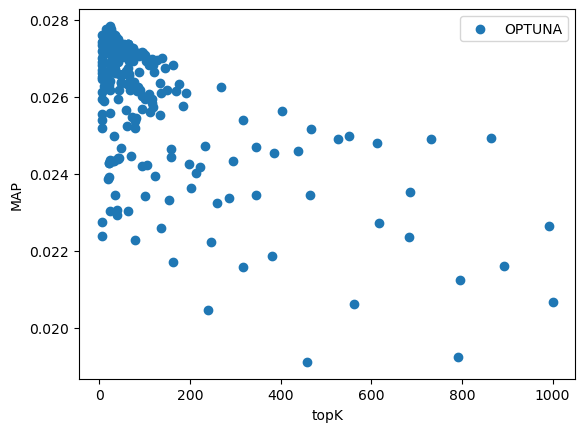

In [18]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_topK"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('topK')
pyplot.legend()
pyplot.show()

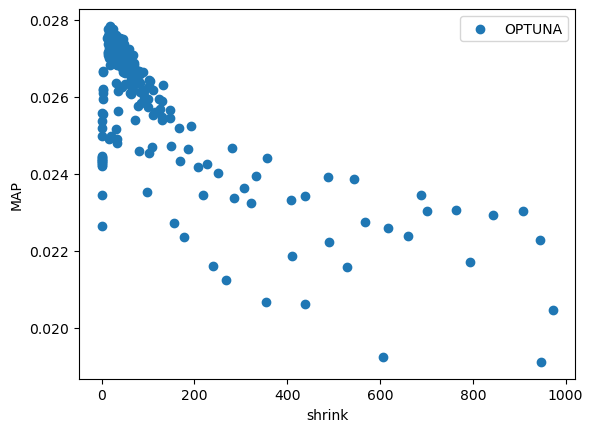

In [19]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_shrink"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('shrink')
pyplot.legend()
pyplot.show()

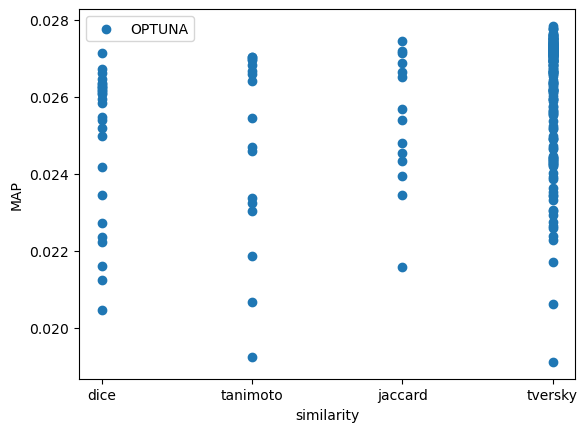

In [20]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_similarity"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('similarity')
pyplot.legend()
pyplot.show()



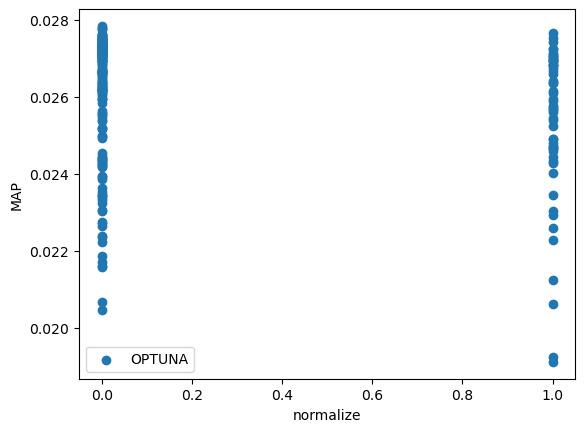

In [21]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_normalize"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('normalize')
pyplot.legend()
pyplot.show()

In [22]:
study.best_value

0.02783583464606791

In [23]:
study.best_params

{'topK': 23, 'shrink': 18, 'similarity': 'tversky', 'normalize': False}

In [24]:
final = model(URM_train_validation)
final.fit(**study.best_params)

ItemKNNCFRecommender: URM Detected 218 ( 1.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 110 ( 0.5%) items with no interactions.
Similarity column 22222 (100.0%), 12357.46 column/sec. Elapsed time 1.80 sec


In [25]:
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=[])
evaluator_test.evaluateRecommender(final)

EvaluatorHoldout: Ignoring 2128 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Processed 10510 (100.0%) in 2.58 sec. Users per second: 4067


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.086156                 0.149837  0.126074  0.043939    0.075515   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.250776  0.137099  0.102361  0.486584      0.328001  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.831619          0.404653    0.831619       0.072774   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.409095                   0.997891             0.208524   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   